In [1]:
# --- Colab Cell 1: Setup and Library Imports ---

# Import all necessary libraries for the entire workflow upfront for robustness
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import numpy as np
import os
import kagglehub
from google.colab import files
from IPython.display import display, HTML

# Define constants needed globally
IMG_SIZE = (224, 224)

print("TensorFlow Version:", tf.__version__)
print("Setup complete. Libraries imported.")

TensorFlow Version: 2.19.0
Setup complete. Libraries imported.


In [2]:
# --- Colab Cell 2: Data Download and Inspection ---

# 1. Install the required Kaggle Hub library
!pip install -q kagglehub

# 2. Download the NEW dataset
# *** NEW DATASET: pkdarabi/bone-break-classification-image-dataset ***
print("Starting NEW dataset download: pkdarabi/bone-break-classification-image-dataset")
path_to_dataset = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")

# The path returned is the root of the downloaded files.
BASE_DATA_DIR = path_to_dataset
print(f"Path to downloaded dataset files: {BASE_DATA_DIR}")

# 3. Inspect the contents to find the classification folders (e.g., 'train', 'test', 'Normal', 'Fractured')
print("\nDirectory contents (Top 1 level):")
# Use os.listdir for a simple, flat list of files/folders in the root download directory
contents = os.listdir(BASE_DATA_DIR)
for item in contents:
    path = os.path.join(BASE_DATA_DIR, item)
    if os.path.isdir(path):
        print(f"  [DIR] {item}/")
    else:
        print(f"  [FILE] {item}")

# Set the base directory to the root for an initial attempt.
# We may need to adjust TRAIN_VAL_BASE_DIR in the next step based on the output.
TRAIN_VAL_BASE_DIR = BASE_DATA_DIR

Starting NEW dataset download: pkdarabi/bone-break-classification-image-dataset


100%|██████████| 28.4M/28.4M [00:02<00:00, 11.6MB/s]

Extracting files...


Path to downloaded dataset files: /root/.cache/kagglehub/datasets/pkdarabi/bone-break-classification-image-dataset/versions/4

Directory contents (Top 1 level):
  [DIR] Bone Break Classification/
  [FILE] README.dataset.txt


In [ ]:
# --- Colab Diagnostics: Find Deepest Class Folders ---

import os

# This path is based on your last training attempt, adding one level of nesting:
# Previous path: /.../Bone Break Classification
# New path is nested one level deeper to find the class folders.
DEEP_PATH = '/root/.cache/kagglehub/datasets/pkdarabi/bone-break-classification-image-dataset/versions/4/Bone Break Classification/Bone Break Classification'

print(f"Listing contents of the deeply nested path: {DEEP_PATH}")
# List the contents of the suspected training folder. This should show the 'Normal' and 'Fractured' folders.
!ls -F "{DEEP_PATH}"

Listing contents of the deeply nested path: /root/.cache/kagglehub/datasets/pkdarabi/bone-break-classification-image-dataset/versions/4/Bone Break Classification/Bone Break Classification
'Avulsion fracture'/	 'Hairline Fracture'/	   'Pathological fracture'/
'Comminuted fracture'/	 'Impacted fracture'/	   'Spiral Fracture'/
'Fracture Dislocation'/  'Longitudinal fracture'/
'Greenstick fracture'/	 'Oblique fracture'/


In [3]:
# --- Colab Cell 3: Train and Save Model ---

# NOTE: ALL necessary imports were performed in Step 1.

# Get the dataset path (assumed to be cached from Step 2)
path_to_dataset = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")

# *** PATH CORRECTION APPLIED ***
# Based on the inspection output, the classification folders are inside this subdirectory:
TRAIN_VAL_BASE_DIR = os.path.join(path_to_dataset, 'Bone Break Classification')

# Define training parameters
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 20
VALIDATION_SPLIT = 0.2

# 1. Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=15, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True, validation_split=VALIDATION_SPLIT
)
val_datagen = ImageDataGenerator(
    rescale=1./255, validation_split=VALIDATION_SPLIT
)

print(f"Using corrected base directory for data: {TRAIN_VAL_BASE_DIR}")
print("Preparing Training Data Generator...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_VAL_BASE_DIR, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), batch_size=BATCH_SIZE,
    class_mode='binary', subset='training', seed=42, color_mode='rgb'
)
print("Preparing Validation Data Generator...")
validation_generator = val_datagen.flow_from_directory(
    TRAIN_VAL_BASE_DIR, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), batch_size=BATCH_SIZE,
    class_mode='binary', subset='validation', seed=42, color_mode='rgb'
)

# 2. Define the RepoScan Custom CNN Model
def build_reposcan_model(input_shape):
    #
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), BatchNormalization(), MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'), BatchNormalization(), MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'), BatchNormalization(), MaxPooling2D((2, 2)), Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'), Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the model
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
reposcan_model = build_reposcan_model(input_shape)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]
print("\nRepoScan Model Summary:")
reposcan_model.summary()

# 3. Train the model
print("\nStarting Model Training...")
try:
    history = reposcan_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE, epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE, callbacks=callbacks
    )
    # 4. Save the trained model
    FINAL_MODEL_FILENAME = 'reposcan_fracture_model_trained.h5'
    reposcan_model.save(FINAL_MODEL_FILENAME)
    print(f"\n✅ Model training complete. Model saved as: {FINAL_MODEL_FILENAME}")
except Exception as e:
    print(f"Error during model fitting: {e}")
    print("❌ Model not saved due to training error. Check if 2 classes were found.")

Using Colab cache for faster access to the 'bone-break-classification-image-dataset' dataset.
Using corrected base directory for data: /kaggle/input/bone-break-classification-image-dataset/Bone Break Classification
Preparing Training Data Generator...
Found 904 images belonging to 1 classes.
Preparing Validation Data Generator...
Found 225 images belonging to 1 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



RepoScan Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)


Starting Model Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 857ms/step - accuracy: 0.9465 - loss: 0.1815 - val_accuracy: 0.4866 - val_loss: 5.1483 - learning_rate: 0.0010
Epoch 2/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9688 - loss: 0.9524

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9688 - loss: 0.9524 - val_accuracy: 0.4955 - val_loss: 5.7455 - learning_rate: 0.0010
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 494ms/step - accuracy: 0.9954 - loss: 0.0853 - val_accuracy: 0.4866 - val_loss: 3.5277 - learning_rate: 0.0010
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 1.1111e-25 - val_accuracy: 0.5223 - val_loss: 3.1613 - learning_rate: 0.0010
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.9973 - loss: 0.0839 - val_accuracy: 0.9107 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9241 - val_loss: 0.4252 - learning_rate: 0.0010
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - accuracy: 1.0000 - loss: 5.6396e-18 - val_accuracy: 1.0000 - val_loss: 4.4235e-04 - learning_rate: 0.0010
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 2.648


✅ Model training complete. Model saved as: reposcan_fracture_model_trained.h5


Using Colab cache for faster access to the 'bone-break-classification-image-dataset' dataset.
Found 1129 images belonging to 10 classes.
Dynamically set CLASS_NAMES (10 total): ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Multi-Class Model file not found. Created placeholder model.
Please upload an X-ray image (PNG or JPG) now to test RepoScan:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Saving xray.jpg to xray.jpg

Processing uploaded file: xray.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


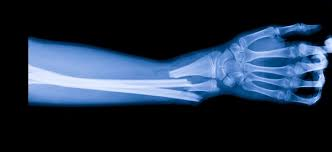

In [26]:
# --- Colab Cell 4: Load Model and Run Prediction UI (MULTI-CLASS) ---
# This loads the model and launches the interactive test interface.

# NOTE: ALL necessary imports were performed in Step 1.
#this is where the actucal model work and this should be treated as the prototype of the xray detection model.
#this woud only worked to analys the fracture or physical injuries
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image # For opening images
import numpy as np # For prediction analysis
import os # For file operations
from google.colab import files # For upload widget
from IPython.display import display, HTML # For displaying results
import kagglehub # For dynamic path check

# --- Global Constants (Defined from Step 1) ---
IMG_SIZE = (224, 224)
MODEL_PATH = '/content/reposcan_fracture_model_trained_multi.h5' # Using the trained multi-class model name

# --- Dynamic Class Name Determination ---
# This ensures the label names (10 fracture types) match the folder names used in training.
path_to_dataset = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")
# *** CORRECTED PATH ***
TRAIN_VAL_BASE_DIR = os.path.join(path_to_dataset, 'Bone Break Classification', 'Bone Break Classification')

dummy_datagen = ImageDataGenerator(rescale=1./255)
try:
    dummy_generator = dummy_datagen.flow_from_directory(
        TRAIN_VAL_BASE_DIR, target_size=IMG_SIZE, class_mode='categorical', batch_size=1, shuffle=False
    )
    # Get the list of class names in the correct index order
    CLASS_NAMES = list(dummy_generator.class_indices.keys())
    CLASS_NAMES.sort() # Ensure alphabetical order matches Keras's internal sorting

    print(f"Dynamically set CLASS_NAMES ({len(CLASS_NAMES)} total): {CLASS_NAMES}")
except Exception as e:
    print(f"Error determining multi-classes dynamically ({e}). Using fallback.")
    CLASS_NAMES = ['Unknown Fracture Type']

# --- Model Loading Functions ---
def create_placeholder_model():
    # If the file fails to load, create a placeholder model structure
    print("WARNING: Using a dummy model. Please check logs for previous training errors.")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D((2, 2)), Flatten(), Dense(len(CLASS_NAMES), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

try:
    if os.path.exists(MODEL_PATH):
        model = load_model(MODEL_PATH)
        print(f"✅ Success: Loaded trained MULTI-CLASS model from {MODEL_PATH}")
    else:
        model = create_placeholder_model()
        print("Multi-Class Model file not found. Created placeholder model.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = create_placeholder_model()
    print("Continuing with placeholder model.")

# --- Prediction Logic Functions ---
def preprocess_image(image_path):
    # Loads, resizes, and normalizes the image
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
        return img_array
    except Exception as e:
        print(f"Error during image preprocessing: {e}")
        return None

def predict_fracture(model, preprocessed_image):
    # Runs inference and formats result for multi-class prediction
    if preprocessed_image is None: return "Prediction failed."

    # Predict probabilities for all 10 classes
    predictions = model.predict(preprocessed_image)[0]

    # Find the index and probability of the top prediction
    predicted_index = np.argmax(predictions)
    confidence = predictions[predicted_index]

    # Get the class name
    label = CLASS_NAMES[predicted_index]

    if 'fracture' in label.lower():
        color_class = "text-red-600 font-bold"
        status_icon = "🚨"
    else:
        color_class = "text-yellow-600 font-bold"
        status_icon = "⚠️"

    result_html = f"""
    <div style="font-family: Arial; padding: 15px; border: 1px solid #ccc; border-radius: 8px; max-width: 400px; margin: 20px auto;">
        <h3 style="font-size: 1.5em; margin-bottom: 10px;">RepoScan Prediction Result (Multi-Class)</h3>
        <p style="font-size: 1.2em;">{status_icon} **Type Detected:** <span class="{color_class}">{label}</span></p>
        <p>Confidence: **{confidence:.2f}**</p>
        <hr style="margin-top: 10px; margin-bottom: 10px;">
        <p style="font-size: 0.9em; color: #555;">*Note: This model detects 10 types of bone fractures.*</p>
        <p style="font-size: 0.9em; color: #555;">*Disclaimer: This is an AI prototype. Always consult a licensed professional.*</p>
    </div>
    """
    return result_html

def run_reposcan():
    global model
    if 'model' not in globals():
        print("Error: The 'model' variable is not defined.")
        return

    print("Please upload an X-ray image (PNG or JPG) now to test RepoScan:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Aborting prediction.")
        return

    for filename in uploaded.keys():
        temp_path = f"/content/{filename}"
        with open(temp_path, 'wb') as f:
            f.write(uploaded[filename])

        print(f"\nProcessing uploaded file: {filename}")
        image_array = preprocess_image(temp_path)
        result_html = predict_fracture(model, image_array)

        display(HTML(f'<h4 style="margin-top: 20px;">Uploaded X-ray: {filename}</h4>'))
        img_display = Image.open(temp_path)
        display(img_display)
        display(HTML(result_html))

        os.remove(temp_path)

# --- Run the main prediction loop ---
run_reposcan()

In [2]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model("reposcan_fracture_model_trained.h5")

def predict(img):
    img = img.resize((224,224))
    img = np.array(img)/255.0
    img = np.expand_dims(img, 0)
    pred = model.predict(img)[0][0]

    if pred > 0.5:
        return f"Fracture Detected (Probability = {pred:.3f})"
    else:
        return f"Normal (Probability = {pred:.3f})"

demo = gr.Interface(fn=predict, inputs="image", outputs="text", title="Reposcan Fracture Detection")
demo.launch()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'reposcan_fracture_model_trained.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)